First I will import the neccessary packages.

In [1]:
import numpy as np

import pandas as pd 

import json 

from geopy.geocoders import Nominatim 

import requests 

from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!pip install folium
import folium

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 6.9 MB/s  eta 0:00:01
Libraries imported.


Getting New York Neighborhood data from the Skills Network

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Formatting the data into a dataframe

In [4]:
neighborhoods_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
...,...,...,...,...
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631


The hidden cell is for my foursquare credentials

In [5]:
# The code was removed by Watson Studio for sharing.

Defining a function to query venues for each neighborhood, filtering the categories to only food categories.

In [6]:
def getNearbyFoodVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    foodCategory = '4d4b7105d754a06374d81259' #obtained from https://developer.foursquare.com/docs/build-with-foursquare/categories/
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT,
            foodCategory)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [7]:
venues = getNearbyFoodVenues(names=neighborhoods['Neighborhood'],
                        latitudes=neighborhoods['Latitude'],
                        longitudes=neighborhoods['Longitude']
                        )

Checking to make sure I have only food categories.

In [8]:
n = 20
venues['Venue Category'].value_counts()[:n].index.tolist()

['Pizza Place',
 'Deli / Bodega',
 'Chinese Restaurant',
 'Italian Restaurant',
 'Bakery',
 'Café',
 'Sandwich Place',
 'Mexican Restaurant',
 'American Restaurant',
 'Donut Shop',
 'Sushi Restaurant',
 'Food Truck',
 'Restaurant',
 'Fast Food Restaurant',
 'Bagel Shop',
 'Diner',
 'Japanese Restaurant',
 'Burger Joint',
 'Thai Restaurant',
 'Fried Chicken Joint']

We also want to make sure that more obscure restaurants are filtered out of the dataset in order to optimise clustering

In [9]:
n = 50
topx = venues['Venue Category'].value_counts()[:n].index.tolist()
venues = venues[venues['Venue Category'].isin(topx)]


In [10]:
venues['Venue Category'].value_counts()

Deli / Bodega                      719
Pizza Place                        719
Chinese Restaurant                 485
Italian Restaurant                 463
Bakery                             353
Café                               299
Sandwich Place                     294
Mexican Restaurant                 287
American Restaurant                254
Donut Shop                         223
Sushi Restaurant                   189
Food Truck                         175
Restaurant                         167
Bagel Shop                         156
Fast Food Restaurant               156
Diner                              145
Japanese Restaurant                141
Burger Joint                       132
Thai Restaurant                    128
Fried Chicken Joint                119
Seafood Restaurant                 118
Food                               116
Korean Restaurant                  112
Indian Restaurant                  109
Latin American Restaurant          108
Spanish Restaurant       

Next we need to find the average occurrence of each type of restaurant in each neighborhood.

In [18]:
categories = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
categories.insert(0, "Neighborhood", venues['Neighborhood'])
categoriesByNeighborhood = categories.groupby('Neighborhood').mean().reset_index()
categoriesByNeighborhood.head()

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,...,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Allerton,0.041667,0.0,0.0,0.000,0.125000,0.041667,0.0,0.0,0.0,...,0.0,0.0,0.083333,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0
1,Annadale,0.166667,0.0,0.0,0.000,0.083333,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.083333,0.0000,0.0,0.0,0.0,0.0
2,Arden Heights,0.000000,0.0,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0
3,Arlington,0.400000,0.0,0.0,0.000,0.000000,0.000000,0.0,0.0,0.2,...,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0
4,Arrochar,0.000000,0.0,0.0,0.125,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0625,0.0,0.0,0.0,0.0


Now we will find the restaurant density in each neighborhood.

In [19]:
neighborhoodDensity = venues.groupby("Neighborhood").count()
neighborhoodDensity.drop(labels=['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'], axis=1, inplace=True)
neighborhoodDensity.rename(columns={'Venue Category' :'Density'},inplace=True)
neighborhoodDensity.head()

,Density
Neighborhood,
Allerton,24
Annadale,12
Arden Heights,2
Arlington,5
Arrochar,16


In [20]:
density_scaled = neighborhoodDensity.copy()
column = 'Density'
density_scaled['Density'] = (density_scaled['Density'] - density_scaled['Density'].min()) / (density_scaled['Density'].max() - density_scaled['Density'].min())    
  
density_scaled

,Density
Neighborhood,
Allerton,0.247312
Annadale,0.118280
Arden Heights,0.010753
Arlington,0.043011
Arrochar,0.161290
...,...
Woodhaven,0.215054
Woodlawn,0.161290
Woodrow,0.096774


Now we'll create a function to return the least common restaurant categories.

In [21]:
def return_least_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_bottom_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_bottom_venues):
    try:
        columns.append('{}{} Least Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Least Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = categoriesByNeighborhood['Neighborhood']

for ind in np.arange(categoriesByNeighborhood.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_least_common_venues(categoriesByNeighborhood.iloc[ind, :], num_bottom_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue
0,Allerton,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant
1,Annadale,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant
2,Arden Heights,American Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant
3,Arlington,Italian Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant
4,Arrochar,American Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant


Now we'll merge both dataframes.

In [23]:
venuesWithDensity = pd.merge(density_scaled, categoriesByNeighborhood, how="inner", on=["Neighborhood"])
venuesWithDensity.head()

,Neighborhood,Density,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Burger Joint,Café,...,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Allerton,0.247312,0.041667,0.0,0.0,0.000,0.125000,0.041667,0.0,0.0,...,0.0,0.0,0.083333,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0
1,Annadale,0.118280,0.166667,0.0,0.0,0.000,0.083333,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.083333,0.0000,0.0,0.0,0.0,0.0
2,Arden Heights,0.010753,0.000000,0.0,0.0,0.000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0
3,Arlington,0.043011,0.400000,0.0,0.0,0.000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0
4,Arrochar,0.161290,0.000000,0.0,0.0,0.125,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0625,0.0,0.0,0.0,0.0


To improve performance, I will scale the columns

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
feature_scaling = MinMaxScaler()
venuesWithDensity1 = venuesWithDensity
venuesWithDensity1.iloc[:,1:] = feature_scaling.fit_transform(venuesWithDensity1.iloc[:,1:])
venuesWithDensity1.describe()

,Density,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,...,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
count,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,...,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000
mean,0.263349,0.034918,0.037515,0.007115,0.052168,0.101185,0.055063,0.016725,0.067820,0.029714,...,0.013614,0.017287,0.058383,0.055250,0.037494,0.054779,0.020704,0.039885,0.012705,0.056996
std,0.257589,0.083555,0.108753,0.060034,0.110117,0.130504,0.146161,0.065258,0.123831,0.102981,...,0.076897,0.091459,0.141650,0.170162,0.088871,0.162322,0.090839,0.103966,0.068395,0.172631
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.064516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.172043,0.000000,0.000000,0.000000,0.000000,0.053763,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.376344,0.041667,0.000000,0.000000,0.058824,0.178571,0.000000,0.015625,0.106383,0.000000,...,0.000000,0.000000,0.043011,0.000000,0.048780,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now we can find the optimal value of K with the elbow method.

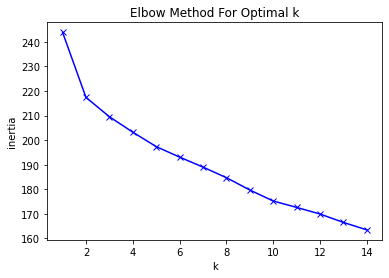

In [27]:
inertia = []

venuesWithDensity_clustering = venuesWithDensity1.drop('Neighborhood', 1)

K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(venuesWithDensity_clustering)
    inertia.append(km.inertia_)
    
import matplotlib.pyplot as plt

plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [28]:
# set number of clusters
kclusters = 2

venuesWithDensity_clustering = venuesWithDensity.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venuesWithDensity_clustering)

#neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = neighborhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
ny_merged = pd.merge(density_scaled, ny_merged, how="inner", on=["Neighborhood"])

print(ny_merged.shape)
ny_merged = ny_merged.dropna()
print(ny_merged.shape)
ny_merged.head() # check the last columns!

(297, 11)
(297, 11)


,Neighborhood,Density,Borough,Latitude,Longitude,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue
0,Allerton,0.247312,Bronx,40.865788,-73.859319,1.0,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant
1,Annadale,0.118280,Staten Island,40.538114,-74.178549,1.0,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant
2,Arden Heights,0.010753,Staten Island,40.549286,-74.185887,1.0,American Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant
3,Arlington,0.043011,Staten Island,40.635325,-74.165104,1.0,Italian Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant
4,Arrochar,0.161290,Staten Island,40.596313,-74.067124,0.0,American Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant


In [29]:
# create map
map_clusters = folium.Map(location=[40.894705, -73.847201], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [30]:
ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[0] + list(range(0, ny_merged.shape[1]))]]

,Neighborhood,Neighborhood,Density,Borough,Latitude,Longitude,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue
4,Arrochar,Arrochar,0.161290,Staten Island,40.596313,-74.067124,0.0,American Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant
6,Astoria,Astoria,0.838710,Queens,40.768509,-73.915654,0.0,American Restaurant,Tapas Restaurant,Taco Place,Steakhouse,Spanish Restaurant
11,Bay Ridge,Bay Ridge,0.795699,Brooklyn,40.625801,-74.030621,0.0,Food Truck,Gastropub,Fried Chicken Joint,French Restaurant,Salad Place
15,Bayside,Bayside,0.569892,Queens,40.766041,-73.774274,0.0,Salad Place,Restaurant,Fast Food Restaurant,Falafel Restaurant,Eastern European Restaurant
22,Belmont,Belmont,0.870968,Bronx,40.857277,-73.888452,0.0,Vietnamese Restaurant,Noodle House,New American Restaurant,Middle Eastern Restaurant,Snack Place
...,...,...,...,...,...,...,...,...,...,...,...,...
274,Upper West Side,Upper West Side,0.537634,Manhattan,40.787658,-73.977059,0.0,Food Truck,Spanish Restaurant,Steakhouse,Mexican Restaurant,Gastropub
279,Washington Heights,Washington Heights,0.752688,Manhattan,40.851903,-73.936900,0.0,Vietnamese Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant
283,West Village,West Village,0.989247,Manhattan,40.734434,-74.006180,0.0,Vietnamese Restaurant,Southern / Soul Food Restaurant,South American Restaurant,Snack Place,Salad Place
295,Woodside,Woodside,0.655914,Queens,40.746349,-73.901842,0.0,Italian Restaurant,Greek Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Mediterranean Restaurant


In [31]:
ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[0] + list(range(0, ny_merged.shape[1]))]]

,Neighborhood,Neighborhood,Density,Borough,Latitude,Longitude,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue
0,Allerton,Allerton,0.247312,Bronx,40.865788,-73.859319,1.0,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant
1,Annadale,Annadale,0.118280,Staten Island,40.538114,-74.178549,1.0,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant
2,Arden Heights,Arden Heights,0.010753,Staten Island,40.549286,-74.185887,1.0,American Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant
3,Arlington,Arlington,0.043011,Staten Island,40.635325,-74.165104,1.0,Italian Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant
5,Arverne,Arverne,0.064516,Queens,40.589144,-73.791992,1.0,American Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
290,Windsor Terrace,Windsor Terrace,0.301075,Brooklyn,40.656946,-73.980073,1.0,Vietnamese Restaurant,Ramen Restaurant,Restaurant,Mediterranean Restaurant,Latin American Restaurant
291,Wingate,Wingate,0.161290,Brooklyn,40.660947,-73.937187,1.0,American Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant
292,Woodhaven,Woodhaven,0.215054,Queens,40.689887,-73.858110,1.0,American Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant
293,Woodlawn,Woodlawn,0.161290,Bronx,40.898273,-73.867315,1.0,Vietnamese Restaurant,Steakhouse,Vegetarian / Vegan Restaurant,Japanese Restaurant,Korean Restaurant


Now lets examine the clusters to make a business recommendation

In [32]:
cluster1 = ny_merged[ny_merged['Cluster Labels'] == 0]
cluster2 = ny_merged[ny_merged['Cluster Labels'] == 1]
print(cluster1.describe())
print(cluster2.describe())

         Density   Latitude  Longitude  Cluster Labels
count  70.000000  70.000000  70.000000            70.0
mean    0.638095  40.726893 -73.961133             0.0
std     0.237562   0.059715   0.066896             0.0
min     0.161290  40.572572 -74.189560             0.0
25%     0.438172  40.703203 -73.994155             0.0
50%     0.645161  40.732317 -73.969531             0.0
75%     0.862903  40.763165 -73.947760             0.0
max     1.000000  40.857277 -73.738898             0.0
          Density    Latitude   Longitude  Cluster Labels
count  227.000000  227.000000  227.000000           227.0
mean     0.153190   40.696471  -73.941442             1.0
std      0.125691    0.104418    0.132612             0.0
min      0.000000   40.505334  -74.246569             1.0
25%      0.053763   40.613198  -74.049328             1.0
50%      0.129032   40.675211  -73.912585             1.0
75%      0.231183   40.782067  -73.847614             1.0
max      0.688172   40.908543  -73.708847

Cluster 1 has a higher average density, which means that there is a higher demand for food in these neighborhoods.

In [33]:
restaurants = cluster1[['1st Least Common Venue', '2nd Least Common Venue', '3rd Least Common Venue', '4th Least Common Venue', '5th Least Common Venue']].apply(pd.Series.value_counts)
restaurants = restaurants.fillna(0)
sum_column = restaurants['1st Least Common Venue'] + restaurants['2nd Least Common Venue'] + restaurants['3rd Least Common Venue'] + restaurants['4th Least Common Venue'] + restaurants['5th Least Common Venue']

restaurants["Totals"] = sum_column

restaurants = restaurants.sort_values(by=['Totals'], ascending = False)
restaurants

,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,Totals
Vietnamese Restaurant,26.0,0.0,0.0,0.0,0.0,26.0
Vegetarian / Vegan Restaurant,0.0,7.0,9.0,5.0,3.0,24.0
Korean Restaurant,0.0,0.0,6.0,7.0,7.0,20.0
Latin American Restaurant,0.0,4.0,4.0,7.0,4.0,19.0
Greek Restaurant,1.0,6.0,4.0,3.0,3.0,17.0
Middle Eastern Restaurant,1.0,7.0,1.0,6.0,1.0,16.0
Gastropub,1.0,2.0,2.0,5.0,5.0,15.0
American Restaurant,15.0,0.0,0.0,0.0,0.0,15.0
Fried Chicken Joint,2.0,4.0,2.0,1.0,4.0,13.0
Japanese Restaurant,0.0,1.0,3.0,5.0,4.0,13.0


From this data we can see that either a Vietnamese or Vegetarian/Vegan Restaurant would be a good choice for a new restaurant.

In [34]:
cluster1 = cluster1.sort_values(by=['Density'], ascending = False)
cluster1

,Neighborhood,Density,Borough,Latitude,Longitude,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue
174,Midtown South,1.000000,Manhattan,40.748510,-73.988713,0.0,Vietnamese Restaurant,Seafood Restaurant,Noodle House,Middle Eastern Restaurant,Mexican Restaurant
150,Lenox Hill,1.000000,Manhattan,40.768113,-73.958860,0.0,Vietnamese Restaurant,Snack Place,Food,Fast Food Restaurant,Falafel Restaurant
250,South Side,0.989247,Brooklyn,40.710861,-73.958001,0.0,Noodle House,Falafel Restaurant,Eastern European Restaurant,Gastropub,Southern / Soul Food Restaurant
283,West Village,0.989247,Manhattan,40.734434,-74.006180,0.0,Vietnamese Restaurant,Southern / Soul Food Restaurant,South American Restaurant,Snack Place,Salad Place
121,Greenwich Village,0.978495,Manhattan,40.726933,-73.999914,0.0,Fast Food Restaurant,Taco Place,South American Restaurant,Food,Noodle House
...,...,...,...,...,...,...,...,...,...,...,...
89,Elmhurst,0.225806,Queens,40.744049,-73.881656,0.0,American Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Korean Restaurant
30,Brighton Beach,0.215054,Brooklyn,40.576825,-73.965094,0.0,American Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant
232,Rockaway Park,0.204301,Queens,40.580343,-73.841534,0.0,American Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Mexican Restaurant
102,Forest Hills Gardens,0.182796,Queens,40.714611,-73.841022,0.0,Italian Restaurant,Greek Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant


From this data we can see that the neighborhoods with the most demand are Midtown South and Lennox Hill, which both lack Vietnamese Restaurants.